## Imports 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from credit_risk_model.config import DATA_PROCESSED, RESULTS_DIR
import shap
import joblib  
from lime.lime_tabular import LimeTabularExplainer

c:\Users\hp\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [16]:
# Load data (processed/feature engineered)
X_train = pd.read_csv(DATA_PROCESSED / "feature_engineered.csv")
X_val = pd.read_csv(DATA_PROCESSED / "feature_engineered_val.csv")
y_val = pd.read_csv(DATA_PROCESSED / "target_val.csv")
# Load trained model
model = joblib.load("../models/XGBoost.joblib")  
booster = model.get_booster()

In [17]:
model_features = booster.feature_names

# Only keep columns the model actually used
X_train = X_train[model_features]
X_val = X_val[model_features]


## SHAP 

In [18]:
# use a sample of validation data for explainability to save computation time
X_sample = X_val.sample(2000, random_state=42)

In [19]:
# SHAP explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

### Summary Plot (importance ranking)

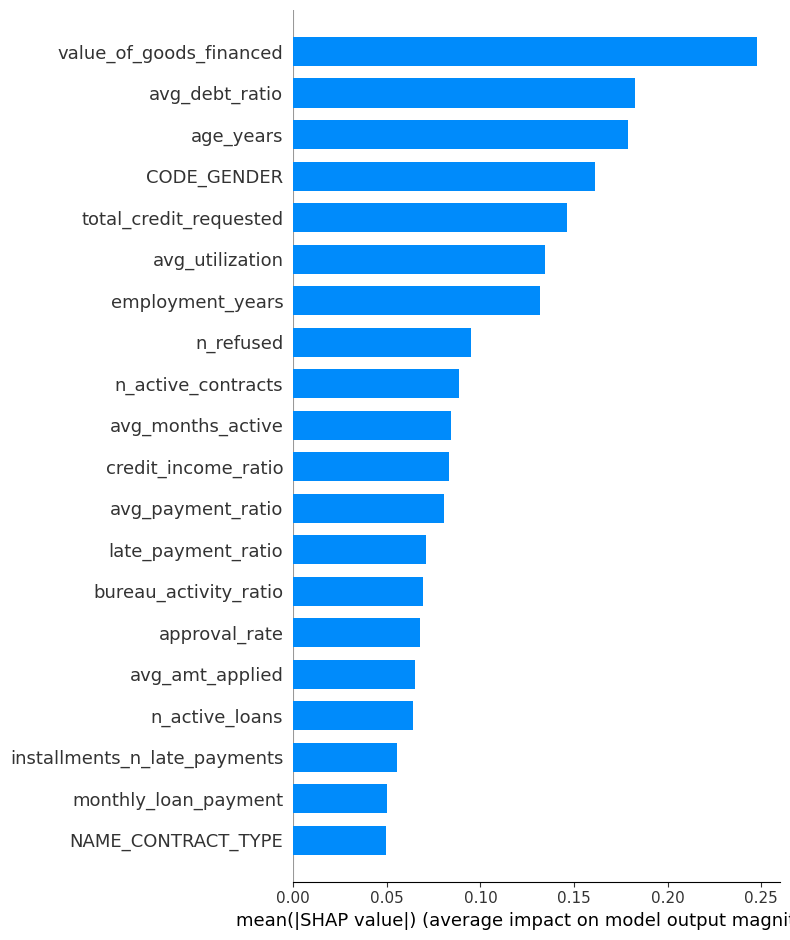

In [20]:
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.savefig(f"{RESULTS_DIR}\\explainability\\shap_summary_bar.png", dpi=300, bbox_inches="tight")

### Full Summary Plot (distribution)

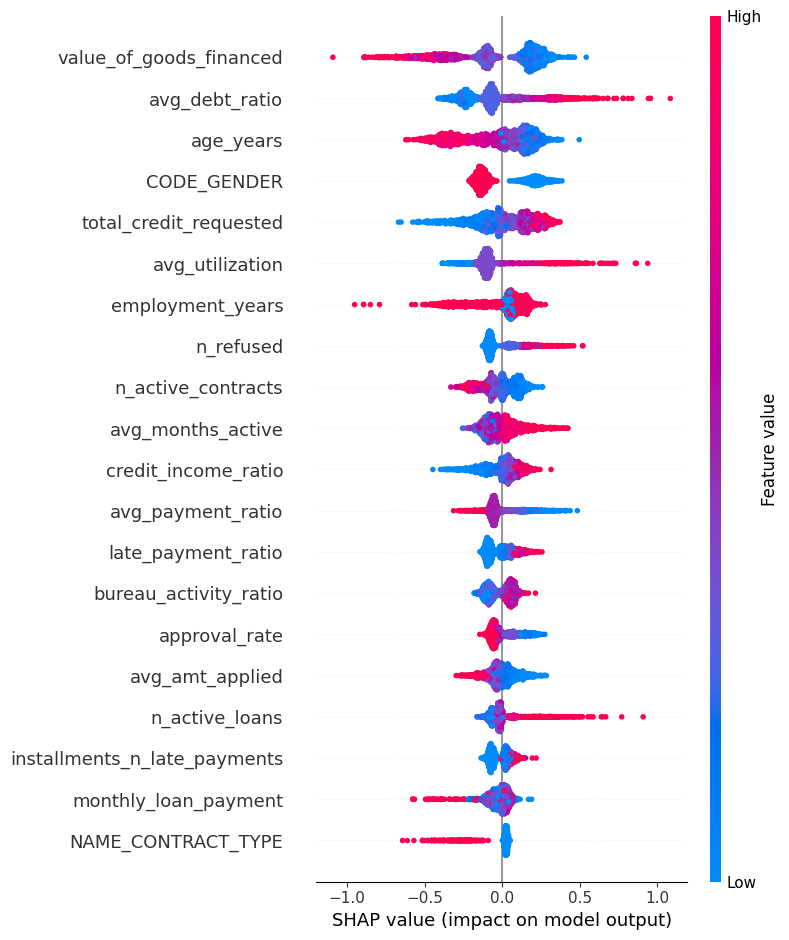

In [21]:
shap.summary_plot(shap_values, X_sample, show=False)
plt.savefig(f"{RESULTS_DIR}\\explainability\\shap_summary.png", dpi=300, bbox_inches="tight")
plt.show()

### Top features: SHAP dependence plots

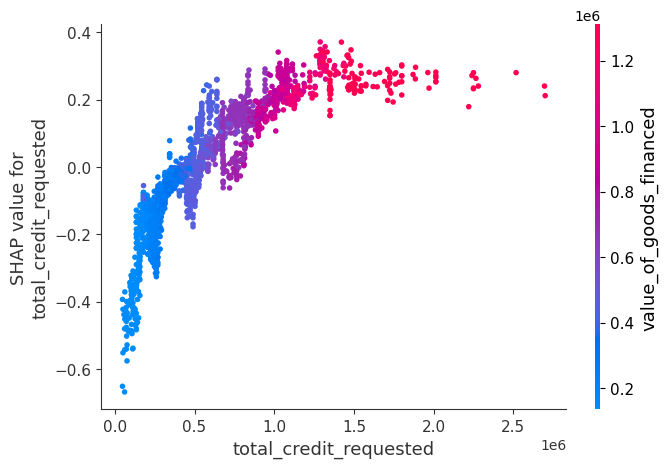

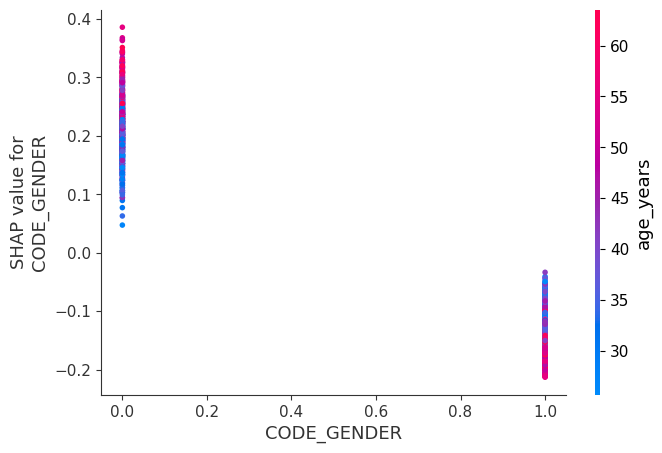

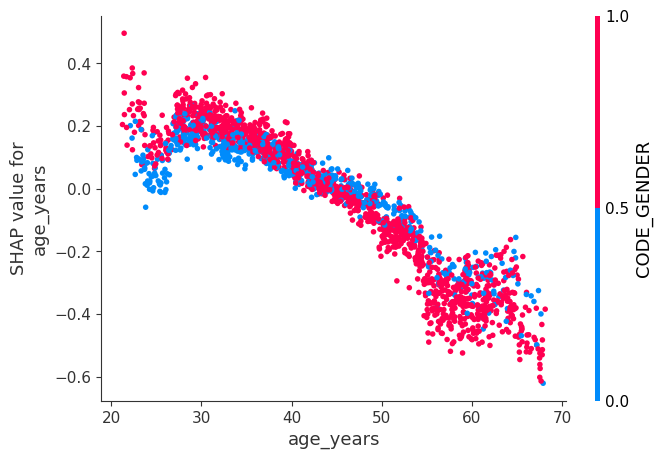

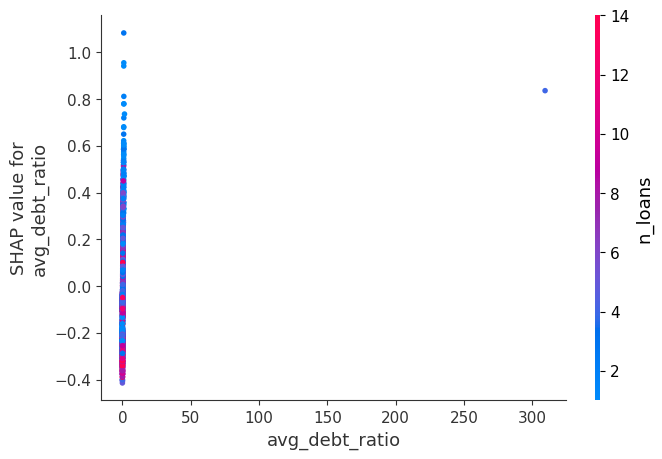

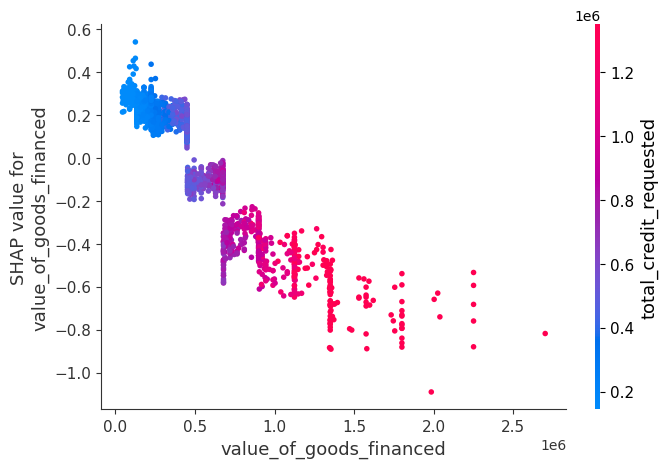

In [22]:
importances = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(importances)[-5:]
top_features = [X_sample.columns[i] for i in top_idx]

top_features
for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_sample, show=False)
    plt.savefig(f"{RESULTS_DIR}\\explainability\\shap_dependence_{feature}.png", dpi=300, bbox_inches="tight")
    plt.show()

## LIME Explainability

In [23]:
X_train_sample = X_train.copy()  
y_train = pd.read_csv(DATA_PROCESSED / "target_train.csv")  
y_train = y_train['target']  

explainer = LimeTabularExplainer(
    training_data=np.array(X_train_sample),
    feature_names=X_train_sample.columns.tolist(),
    class_names=["Non-default", "Default"],
    mode="classification",
    discretize_continuous=True
)


#### Explain a random sample

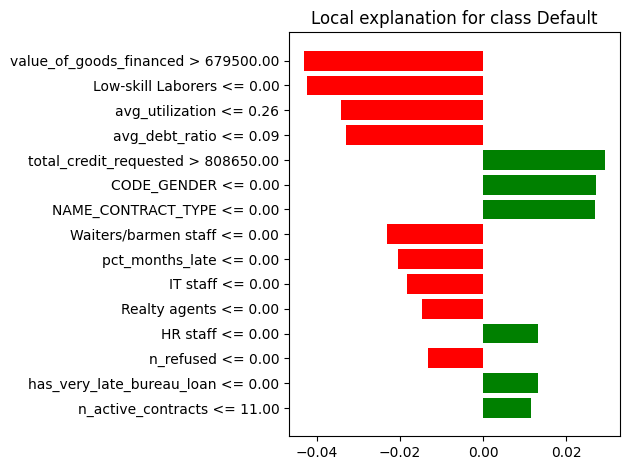

In [24]:
# Pick an instance from validation set
i = 25
instance = X_val.iloc[i].values

# Generate explanation
lime_exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=model.predict_proba,
    num_features=15
)

fig = lime_exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}\\explainability\\lime_instance_{i}.png", dpi=300, bbox_inches="tight")
plt.show()


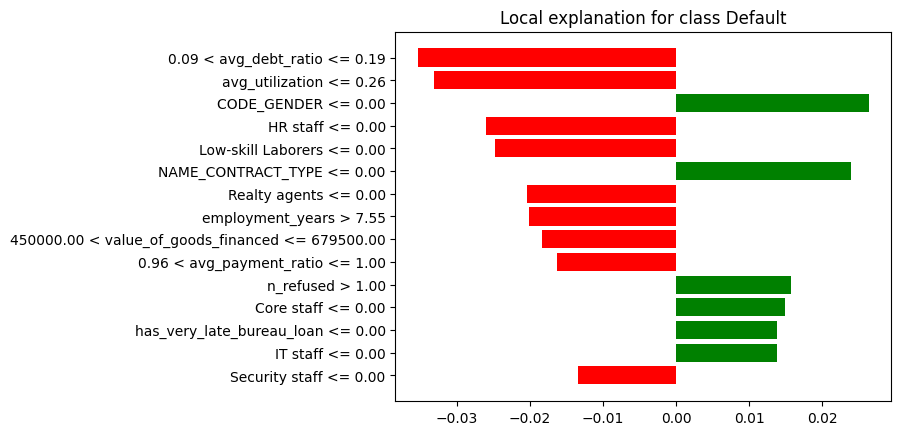

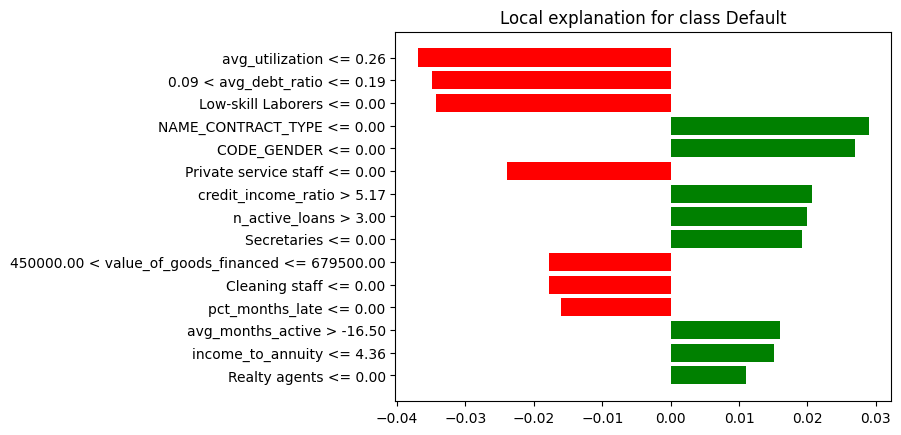

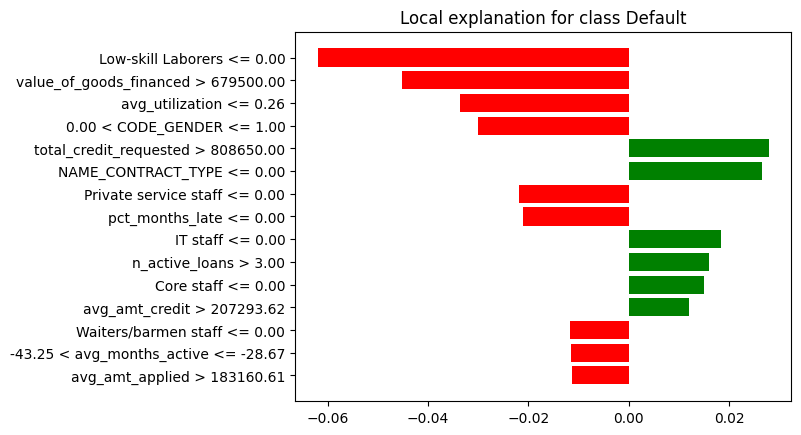

In [25]:
for i in [5, 23, 50]:
    instance = X_val.iloc[i].values
    lime_exp = explainer.explain_instance(instance, model.predict_proba, num_features=15)
    fig = lime_exp.as_pyplot_figure()
    plt.savefig(f"{RESULTS_DIR}\\explainability\\lime_instance_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()


### ROC AUC curve

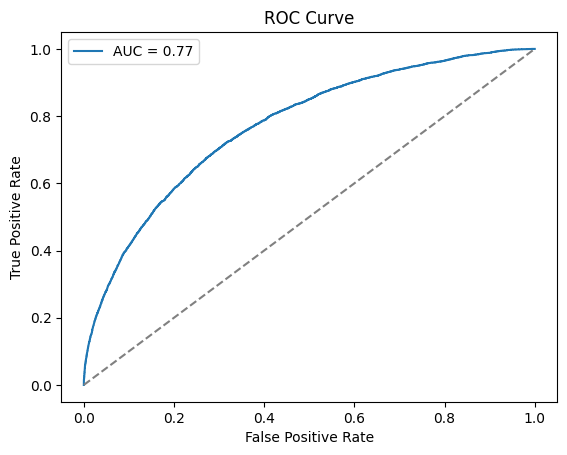

<Figure size 640x480 with 0 Axes>

### Confusion Matrix

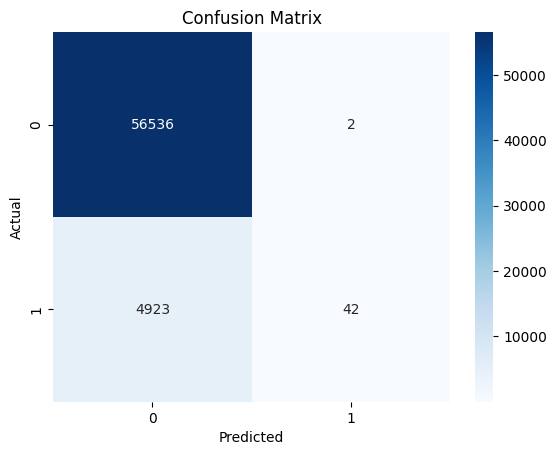

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred_xgb)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
